In [1]:
!pip install xgboost

#### Importing all the required libraries

In [26]:
import itertools
import pickle
import random
import matplotlib
import math
import copy
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imutils import paths
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from collections import Counter

#### Reading dataset path and loading images

In [40]:
from imutils import paths

print("Loading images...")
data = []
labels = []

imagePaths = sorted(list(paths.list_images("./data/training/")))
random.seed(42)
random.shuffle(imagePaths)

for imagePath in imagePaths:
    image = cv2.imread(imagePath, 0)
    image = cv2.resize(image, (40, 40))
    image = np.reshape(image, 1600)
    data.append(image)

    label = imagePath[-7:-4]
    if label == "pos":
        label = 1
    else:
        label = 0
    labels.append(label)

data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

Loading images...


#### Displaying array sample

In [36]:
# displaying image array
print(data[:4])

# displaying labels
print(labels[:4])

[[0.01176471 0.07058824 0.09411765 ... 0.11372549 0.10196078 0.11764706]
 [0.68627451 0.68235294 0.74509804 ... 0.11372549 0.12156863 0.09803922]
 [0.16862745 0.20392157 0.29019608 ... 0.19215686 0.06666667 0.20784314]
 [0.22745098 0.24313725 0.28235294 ... 0.19607843 0.14117647 0.11764706]]
[0 0 1 1]


#### Displaying training image

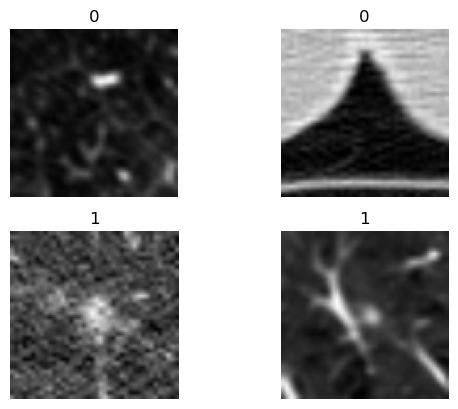

In [37]:
for i, images in enumerate(imagePaths[:4]):
    img = cv2.imread(images)
    img = cv2.resize(img, (100, 100))
    plt.subplot(2, 2, i + 1)
    plt.title(labels[i])
    plt.imshow(img)
    plt.grid(False)
    plt.axis('off')
plt.show()

#### Splitting dataset into train-test

In [41]:
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.25, random_state=3)


In [42]:
trainX.shape, testX.shape


((2206, 1600), (736, 1600))

#### NCA-XGBoosting

In [43]:
dim = len(trainX[0])
n_classes = len(np.unique(trainY))

In [17]:
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=2, random_state=3),
)

In [44]:
xgb = XGBClassifier(n_estimators=3)

In [45]:
nca.fit(trainX, trainY)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('neighborhoodcomponentsanalysis',
                 NeighborhoodComponentsAnalysis(n_components=2,
                                                random_state=3))])

In [46]:
xgb.fit(nca.transform(trainX), trainY)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=3, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [47]:
print("Accuracy score -->" ,accuracy_score(xgb.predict(nca.transform(testX)), testY))

Accuracy score --> 0.7595108695652174


In [48]:
print(classification_report(testY, xgb.predict(nca.transform(testX))))

              precision    recall  f1-score   support

           0       0.73      0.84      0.78       378
           1       0.80      0.67      0.73       358

    accuracy                           0.76       736
   macro avg       0.77      0.76      0.76       736
weighted avg       0.76      0.76      0.76       736



In [49]:
confusion_matrix(testY, xgb.predict(nca.transform(testX)))

array([[318,  60],
       [117, 241]])

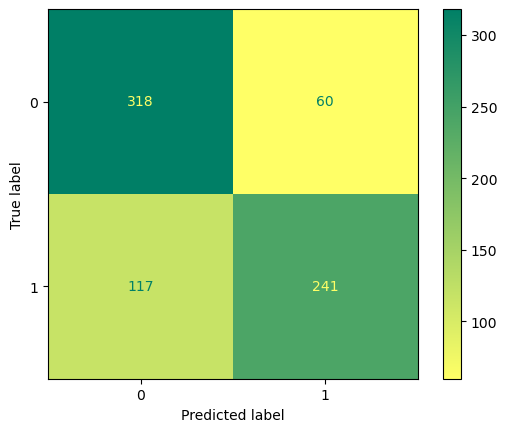

In [51]:
# Assuming you have trained your XGBClassifier model and obtained the predicted labels
y_pred = xgb.predict(nca.transform(testX))

# Compute the confusion matrix
cm = confusion_matrix(testY, y_pred)

# Create the ConfusionMatrixDisplay object and plot the confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
cmd.plot(cmap="summer_r")
plt.show()


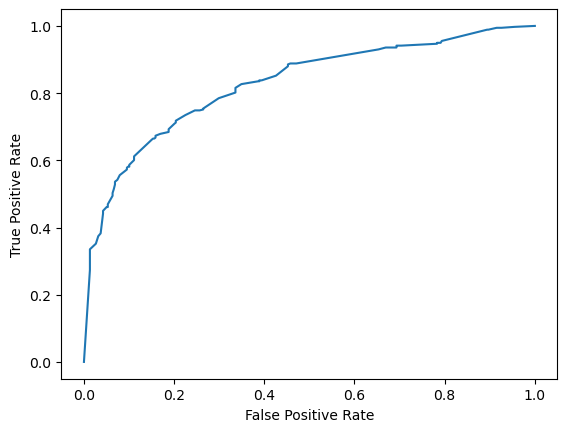

In [54]:
from sklearn.metrics import roc_curve

# Assuming you have trained your XGBClassifier model and obtained the predicted probabilities
y_proba = xgb.predict_proba(nca.transform(testX))

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(testY, y_proba[:, 1])

# Create the RocCurveDisplay object and plot the ROC curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot()
plt.show()


#### KNN Classifier

In [56]:
knn = KNeighborsClassifier(n_neighbors=5)

In [57]:
knn.fit(trainX, trainY)

KNeighborsClassifier()

In [58]:
print("Accuracy score -->" ,accuracy_score(knn.predict(testX), testY))

Accuracy score --> 0.9171195652173914


In [59]:
print(classification_report(testY, knn.predict(testX)))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       378
           1       0.93      0.90      0.91       358

    accuracy                           0.92       736
   macro avg       0.92      0.92      0.92       736
weighted avg       0.92      0.92      0.92       736



In [60]:
confusion_matrix(testY, knn.predict(testX))

array([[354,  24],
       [ 37, 321]])

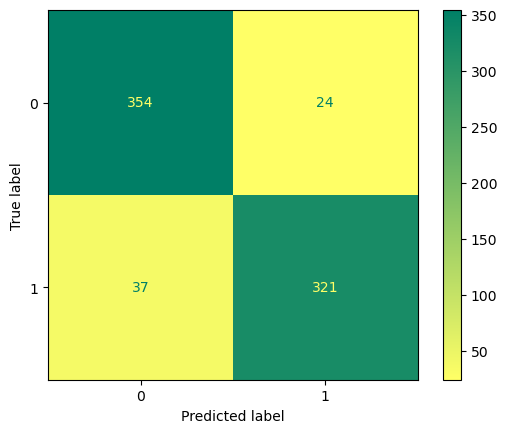

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have already trained and fitted your KNeighborsClassifier (knn)

# Get the predicted labels
y_pred = knn.predict(testX)

# Compute the confusion matrix
cm = confusion_matrix(testY, y_pred)

# Create the ConfusionMatrixDisplay object and plot the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
cm_display.plot(cmap="summer_r")
plt.show()


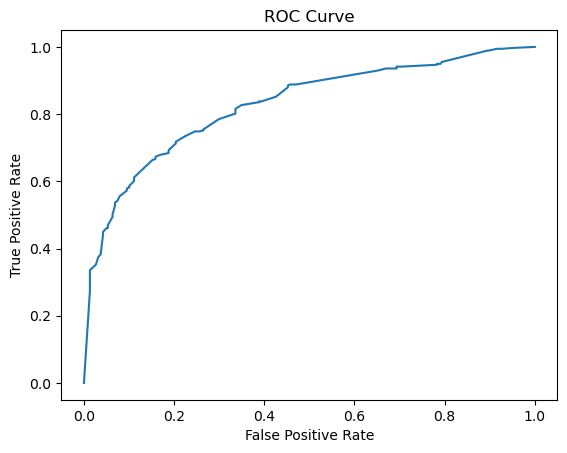

In [67]:
from sklearn.metrics import roc_curve

# Assuming you have already trained and fitted your XGBClassifier (xgb)

# Get the predicted probabilities
y_proba = xgb.predict_proba(nca.transform(testX))

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(testY, y_proba[:, 1])

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


#### Adaboost Classifier

In [68]:
ada = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1.0,
                         algorithm='SAMME.R')

In [69]:
ada.fit(trainX, trainY)

AdaBoostClassifier()

In [70]:
print("Accuracy score -->" ,accuracy_score(ada.predict(testX), testY))

Accuracy score --> 0.8627717391304348


In [71]:
print(classification_report(testY, ada.predict(testX)))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       378
           1       0.87      0.84      0.86       358

    accuracy                           0.86       736
   macro avg       0.86      0.86      0.86       736
weighted avg       0.86      0.86      0.86       736



In [72]:
confusion_matrix(testY, ada.predict(testX))

array([[334,  44],
       [ 57, 301]])

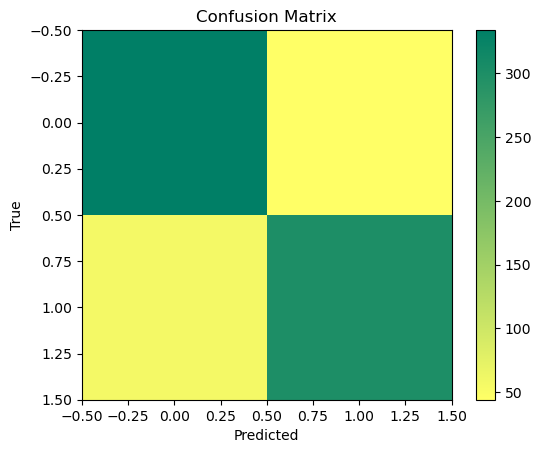

In [76]:
from sklearn.metrics import confusion_matrix

# Assuming you have already trained and fitted your AdaBoostClassifier (ada)

# Get the predicted labels
y_pred = ada.predict(testX)

# Compute the confusion matrix
cm = confusion_matrix(testY, y_pred)

# Plot the confusion matrix
plt.imshow(cm, cmap='summer_r')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


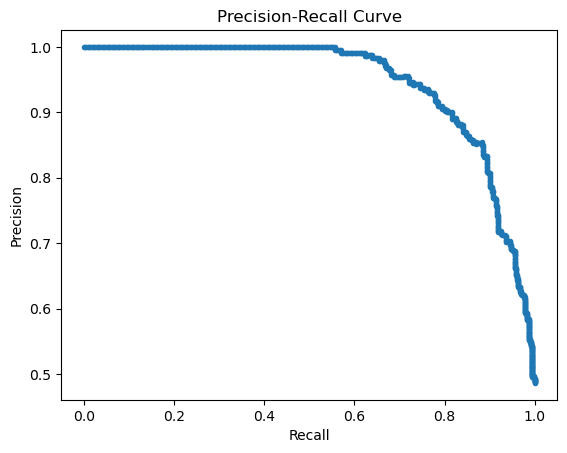

In [77]:
from sklearn.metrics import precision_recall_curve

# Assuming you have already trained and fitted your AdaBoostClassifier (ada)

# Get the predicted probabilities
y_proba = ada.predict_proba(testX)
y_proba_positive = y_proba[:, 1]

# Compute precision and recall values
precision, recall, _ = precision_recall_curve(testY, y_proba_positive)

# Plot the precision-recall curve
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
